In [1]:
import os

import scipy.io

import numpy as np
import matplotlib.pyplot as plt
import cv2

from tqdm.notebook import tqdm

from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
plt.rcParams["figure.figsize"] = 16, 9

In [3]:
def load_image(path):
    """Load an image given its path."""
    img = cv2.imread(path)
    img = img[..., ::-1]
    return img[..., :3]


def draw_boxes(img, boxes):
    """Draw boxes on image."""
    for box in boxes:
        img = cv2.polylines(img, [np.array(box).reshape(4, 2).astype(np.int32)],
                            1,
                            (255, 0, 0))
    return img

In [4]:
class SynthTextInTheWildDataset(object):
    def __init__(self, img_root="./SynthText/", annotations_file="./SynthText/gt.mat"):
        self.img_root = img_root
        self.annotations_file = annotations_file
        
        ann_mat = scipy.io.loadmat(annotations_file)
        self.ann_mat = ann_mat
        
    def __len__(self):
        return self.ann_mat["imnames"].shape[1]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_root, self.ann_mat["imnames"][0][idx].item())
        assert os.path.isfile(img_path)
        
        img = load_image(img_path)
        img = img/np.float32(255)
        
        wordBBs = np.transpose(self.ann_mat["wordBB"][0][idx], [2, 1, 0])
#         print(wordBBs.shape)
        
        num_boxes = wordBBs.shape[0]
        
        objects = []
        for i in range(num_boxes):
#             img = cv2.polylines(img, [wordBBs[i].astype(np.int32)], 1, (255, 0, 0))
            objects.append({
                "quad": wordBBs[i].astype(np.int32).reshape(-1).tolist(),
                "text": "Don't care"
            })
            
        return {
            "idx": idx,
            "image": img,
            "objects": objects
        }

In [5]:
# ds = SynthTextInTheWildDataset()
ds = SynthTextInTheWildDataset(img_root="/mnt/9C5E1A4D5E1A2116/datasets/SynthText/SynthText/",
                               annotations_file="/mnt/9C5E1A4D5E1A2116/datasets/SynthText/SynthText/gt.mat")

In [6]:
ds[0]

{'idx': 0, 'image': array([[[0.03921569, 0.03921569, 0.03137255],
         [0.02745098, 0.02745098, 0.01960784],
         [0.03137255, 0.02745098, 0.01176471],
         ...,
         [0.01568628, 0.00784314, 0.02745098],
         [0.01568628, 0.00784314, 0.02745098],
         [0.01960784, 0.01176471, 0.03137255]],
 
        [[0.03529412, 0.03529412, 0.02745098],
         [0.02352941, 0.02352941, 0.01568628],
         [0.02745098, 0.02352941, 0.00784314],
         ...,
         [0.01960784, 0.01176471, 0.03137255],
         [0.02352941, 0.01568628, 0.03529412],
         [0.02352941, 0.01568628, 0.03529412]],
 
        [[0.03137255, 0.03137255, 0.02352941],
         [0.01960784, 0.01960784, 0.01176471],
         [0.02352941, 0.01960784, 0.00392157],
         ...,
         [0.02745098, 0.01960784, 0.03137255],
         [0.03137255, 0.02352941, 0.03529412],
         [0.03529412, 0.02745098, 0.03921569]],
 
        ...,
 
        [[0.53333336, 0.40784314, 0.30980393],
         [0.5372549 , 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


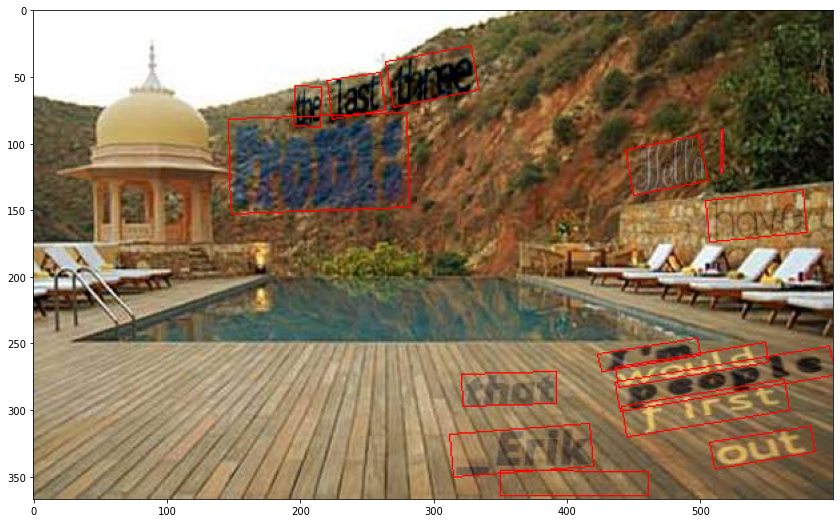

In [34]:
idx = np.random.randint(len(ds))
img = ds[idx]["image"]
boxes = [d["quad"] for d in ds[idx]["objects"]]

plt.imshow(draw_boxes(img, boxes))

## Convert job

In [ ]:
img_outdir = "./converted/img/"
annotations_dir = "./converted/gt/"

os.makedirs(img_outdir, exist_ok=True)
os.makedirs(annotations_dir, exist_ok=True)

In [ ]:
# max_workers = 8

# with ThreadPoolExecutor(max_workers=max_workers) as ex:
#     futures = []
    
#     for i in range(len(ds)):
#         futures.append(ex.submit(ds.__getitem__, i))
        
#     for future in tqdm(as_completed(futures), total=len(futures)):
#         try:
#             data = future.result()
            
#             cv2.imwrite(os.path.join(img_outdir, f"img_{data['idx']}.jpg"), (data["image"][..., ::-1] * 255).astype(np.uint8))
            
#             with open(os.path.join(annotations_dir, f"gt_img_{data['idx']}.txt"), "w") as f:
#                 for rec in data["objects"]:
#                     f.write(f'{str(rec["quad"]).replace("[", "").replace("]", "").replace(" ", "")},text here\n')
#         except Exception as e:
#             print(str(e))

In [ ]:
for i in tqdm(range(len(ds)), total=len(ds)):
    try:
        data = ds[i]
        cv2.imwrite(os.path.join(img_outdir, f"img_{data['idx']}.jpg"), (data["image"][..., ::-1] * 255).astype(np.uint8))

        with open(os.path.join(annotations_dir, f"gt_img_{data['idx']}.txt"), "w") as f:
            for rec in data["objects"]:
                f.write(f'{str(rec["quad"]).replace("[", "").replace("]", "").replace(" ", "")},text here\n')
    except Exception as e:
        print(str(e))